In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [2]:
my_data_dir = '../input/files1/Malaria Cells'

In [3]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['testing_set', 'single_prediction', 'training_set']

In [4]:
test_path = my_data_dir+'/testing_set'
train_path = my_data_dir+'/training_set'

In [5]:
os.listdir(test_path)

['Uninfected', 'Parasitized']

In [6]:
os.listdir(train_path)

['Uninfected', 'Parasitized']

In [7]:
os.listdir(train_path+'/Parasitized')[0]

'C99P60ThinF_IMG_20150918_141001_cell_93.png'

In [8]:
para_cell = train_path+'/Parasitized'+'/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [9]:
para_img= imread(para_cell)

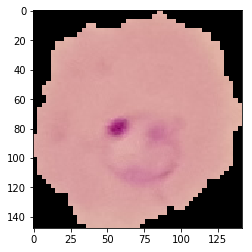

In [10]:
plt.imshow(para_img)

In [11]:
para_img.shape

(148, 142, 3)

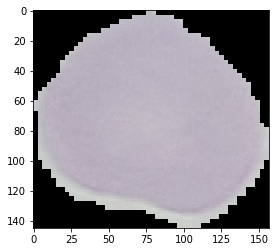

In [12]:
unifected_cell_path = train_path+'/Uninfected/'+os.listdir(train_path+'//Uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [13]:
len(os.listdir(train_path+'/Parasitized'))

13780

In [14]:
len(os.listdir(train_path+'/Uninfected'))

13780

In [15]:
unifected_cell.shape

(145, 157, 3)

In [16]:
para_img.shape

(148, 142, 3)

In [ ]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/Uninfected'):
    
    img = imread(test_path+'/Uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [ ]:
sns.jointplot(dim1,dim2)

In [ ]:
np.mean(dim1)

In [ ]:
np.mean(dim2)

In [ ]:
image_shape = (130,130,3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
help(ImageDataGenerator)

In [ ]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [ ]:
plt.imshow(para_img)

In [ ]:
plt.imshow(image_gen.random_transform(para_img))

In [ ]:
plt.imshow(image_gen.random_transform(para_img))

In [ ]:
image_gen.flow_from_directory(train_path)

In [ ]:
image_gen.flow_from_directory(test_path)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Initialising the CNN
classifier = Sequential()

#1 - Convolution
classifier.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#2 - Pooling
# Hidden Layer 1
classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a second convolution layer
# relu turns negative values in images to 0
classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#3 - Flattening
# converts the matrix in a singe array
classifier.add(Flatten())


classifier.add(Dense(128))
classifier.add(Activation('relu'))


# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
classifier.add(Dropout(0.5))

#4 - Full Connection
# 128 is the final layer of outputs & from that 1 will be considered.
# Last layer, remember its binary so we use sigmoid
classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))

classifier.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
classifier.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
batch_size = 16

In [ ]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

In [ ]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

In [ ]:
train_image_gen.class_indices

In [ ]:
results = classifier.fit_generator(train_image_gen,epochs=5,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

> I used 0.5 or 50% dropping of neurons while training to avoid overfitting problem (dropout)

In [ ]:
from tensorflow.keras.models import load_model
classifier.save('malaria_detector.h5')

In [ ]:
losses = pd.DataFrame(classifier.history.history)

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
classifier.metrics_names

In [ ]:
classifier.evaluate_generator(test_image_gen)

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
pred_probabilities = classifier.predict_generator(test_image_gen)

In [ ]:
pred_probabilities

In [ ]:
test_image_gen.classes

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
# Numpy can treat this as True/False for us
predictions

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(test_image_gen.classes,predictions))

In [ ]:
confusion_matrix(test_image_gen.classes,predictions)

In [ ]:
# Your file path will be different!
para_cell

In [ ]:
my_image = image.load_img(para_cell,target_size=image_shape)

In [ ]:
my_image

In [ ]:
type(my_image)

In [ ]:
my_image = image.img_to_array(my_image)

In [ ]:
type(my_image)

In [ ]:
my_image.shape

In [ ]:
my_image = np.expand_dims(my_image, axis=0)

In [ ]:
my_image.shape

In [ ]:
classifier.predict(my_image)

In [ ]:
train_image_gen.class_indices

In [ ]:
test_image_gen.class_indices

>Thank You